##### Notebook 2: Model Training

Welcome to Notebook 2 of this recommendation system project!

In Notebook 1, we performed exploratory data analysis (EDA), and visualized various aspects of the data to gain insights into our anime recommendation problem.

In this notebook, we will focus on training the recommendation model. By separating the model training into a separate notebook, we ensure better memory management and organization of the project.

Let's dive in!

Note: If you haven't gone through Notebook 1 yet, I highly recommend you do so to understand the data and insights gained before moving on to the model training phase.

[Click here to access Notebook 1: Exploratory Data Analysis and Dataset Preparation](https://www.kaggle.com/code/dbdmobile/anime-recommendation-1)

In [6]:
!pip install wordcloud -q

In [7]:
### Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import warnings
warnings.filterwarnings(action='ignore')

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Model Training
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

## Import necessary modules for collaborative filtering
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from wordcloud import WordCloud
from collections import defaultdict
from collections import Counter

## Import necessary modules for content-based filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [8]:
# Load the dataset
import pandas as pd
df=pd.read_csv('../model/users-score-2023.csv', usecols=["user_id","anime_id","rating"])
print("Shape of the Dataset:",df.shape)
df.head()

Shape of the Dataset: (24325191, 3)


,user_id,anime_id,rating
0,1,21,9
1,1,48,7
2,1,320,5
3,1,49,8
4,1,304,8


In [9]:
# Checking if there are any duplicate rows
duplicated_rows = df[df.duplicated()]
print("Duplicated Rows:")
print(duplicated_rows)

Duplicated Rows:
Empty DataFrame
Columns: [user_id, anime_id, rating]
Index: []


In [10]:
# Calculating the average score
avg_score = np.mean(df['rating'])
print('Average Score:', avg_score)

Average Score: 7.622930072779285


# Data Preprocessing

In [11]:
# Scaling our "rating" column
# Create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the 'score' column between 0 and 1
df['scaled_score'] = scaler.fit_transform(df[['rating']])

In [12]:
# Encoding categorical data

## Encoding user IDs
user_encoder = LabelEncoder()
df["user_encoded"] = user_encoder.fit_transform(df["user_id"])
num_users = len(user_encoder.classes_)

## Encoding anime IDs
anime_encoder = LabelEncoder()
df["anime_encoded"] = anime_encoder.fit_transform(df["anime_id"])
num_animes = len(anime_encoder.classes_)

# Printing dataset information
print("Number of unique users: {}, Number of unique anime: {}".format(num_users, num_animes))
print("Minimum rating: {}, Maximum rating: {}".format(min(df['rating']), max(df['rating'])))

Number of unique users: 270033, Number of unique anime: 16500
Minimum rating: 1, Maximum rating: 10


# Model training (collaborative filtering)

In [13]:
# Shuffle the dataset
df = shuffle(df, random_state=100)

# Create feature matrix X and target variable y
X = df[['user_encoded', 'anime_encoded']].values
y = df["scaled_score"].values

# Printing dataset information
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (24325191, 2)
Shape of y: (24325191,)


In [14]:
test_set_size = 10000  # Number of samples to include in the test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=73)

print("Number of samples in the training set:", len(y_train))
print("Number of samples in the test set:", len(y_test))

Number of samples in the training set: 24315191
Number of samples in the test set: 10000


In [15]:
# Prepare input data for model training and evaluation
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [17]:
import tensorflow as tf

# Set flag to use TPU
USE_TPU = True

try:
    if USE_TPU:
        print("🔌 Attempting to connect to TPU...")
        # Automatically detect and connect to TPU
        tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # No .connect() needed here
        tf.config.experimental_connect_to_cluster(tpu_resolver)
        tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
        tpu_strategy = tf.distribute.TPUStrategy(tpu_resolver)
        print("✅ TPU initialized.")
    else:
        print("Using CPU/GPU backend.")
        # If on Colab or local with GPU, show GPU info (optional)
        # This line is specific to Jupyter or Colab
        # You can use `!nvidia-smi` only in notebooks
        # print("GPU Info:")
        # !nvidia-smi
except ValueError as e:
    print(f"❌ TPU not found or failed to connect: {e}")
    USE_TPU = False
    tpu_strategy = None

# Print TensorFlow version
print(f"🧠 TensorFlow version: {tf.__version__}")


🔌 Attempting to connect to TPU...
❌ TPU not found or failed to connect: Please provide a TPU Name to connect to.
🧠 TensorFlow version: 2.17.0


In [18]:
def RecommenderNet(num_users, num_animes, embedding_size=128):
    # User input layer and embedding layer
    user = Input(name='user_encoded', shape=[1])
    user_embedding = Embedding(name='user_embedding', input_dim=num_users, output_dim=embedding_size)(user)
    
    # Anime input layer and embedding layer
    anime = Input(name='anime_encoded', shape=[1])
    anime_embedding = Embedding(name='anime_embedding', input_dim=num_animes, output_dim=embedding_size)(anime)
    
    # Dot product of user and anime embeddings
    dot_product = Dot(name='dot_product', normalize=True, axes=2)([user_embedding, anime_embedding])
    flattened = Flatten()(dot_product)
    
    # Dense layers for prediction
    dense = Dense(64, activation='relu')(flattened)
    output = Dense(1, activation='sigmoid')(dense)
    
    # Create and compile the model
    model = Model(inputs=[user, anime], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=["mae", "mse"])
    
    return model
# Checking if TPU is initialized and create the model accordingly
if USE_TPU:
    with tpu_strategy.scope():
        model = RecommenderNet(num_users, num_animes)
else:
    model = RecommenderNet(num_users, num_animes)

# Printing my model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_encoded        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_encoded       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │ 34,564,224 │ user_encoded[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,112,000 │ anime_encoded[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        128 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 36,676,417 (139.91 MB)

 Trainable params: 36,676,417 (139.91 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
## Import necessary callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

# Define the initial learning rate, minimum learning rate, maximum learning rate, and batch size
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

# Adjust the maximum learning rate and batch size if using TPU
if USE_TPU:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

# Define the number of epochs for ramp-up, sustain, and exponential decay
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

# Learning rate schedule function
def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr) / rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr

# Learning rate scheduler callback
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

# File path for saving the model weights
checkpoint_filepath = '/kaggle/working/myanimeweights.weights.h5'


# Model checkpoint callback to save the best weights
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

# Define the list of callbacks
my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping
]

In [21]:
# Model training
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/20
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 470s 192ms/step - loss: 0.6845 - mae: 0.2559 - mse: 0.0854 - val_loss: 0.6562 - val_mae: 0.2284 - val_mse: 0.0709 - learning_rate: 1.0000e-05
Epoch 2/20
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 476s 195ms/step - loss: 0.6402 - mae: 0.2138 - mse: 0.0635 - val_loss: 0.5997 - val_mae: 0.1722 - val_mse: 0.0435 - learning_rate: 1.8000e-05
Epoch 3/20
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 474s 194ms/step - loss: 0.5900 - mae: 0.1600 - mse: 0.0396 - val_loss: 0.5772 - val_mae: 0.1468 - val_mse: 0.0336 - learning_rate: 2.6000e-05
Epoch 4/20
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 474s 194ms/step - loss: 0.5768 - mae: 0.1459 - mse: 0.0339 - val_loss: 0.5750 - val_mae: 0.1423 - val_mse: 0.0328 - learning_rate: 3.4000e-05
Epoch 5/20
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 474s 194ms/step - loss: 0.5672 - mae: 0.1349 - mse: 0.0302 - val_loss: 0.5590 - val_mae: 0.1263 - val_mse: 0.0268 - learning_rate: 4.2000e-05
Epoch 6/20
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 477s 196ms/step - loss: 0.5469 - mae: 

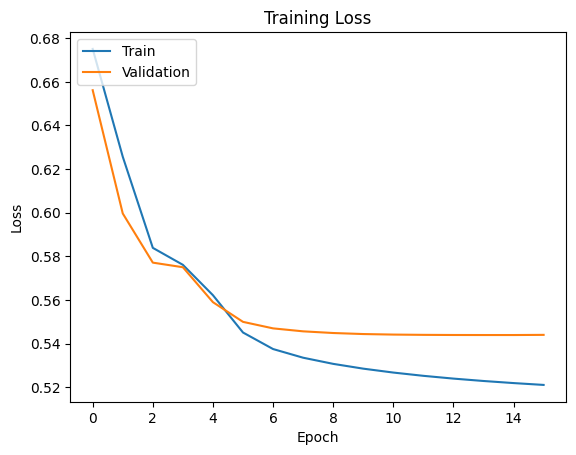

In [22]:
# Training results visualization

plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

# Recommendation:

In [23]:
def extract_weights(name, model):
    # Get the layer by name from the model
    weight_layer = model.get_layer(name)
    
    # Get the weights from the layer
    weights = weight_layer.get_weights()[0]
    
    # Normalize the weights
    weights = weights / np.linalg.norm(weights, axis=1).reshape((-1, 1))
    
    return weights

# Extract weights for anime embeddings
anime_weights = extract_weights('anime_embedding', model)
# Extract weights for user embeddings
user_weights = extract_weights('user_embedding', model)

#### Reading the whole dataset

In [25]:
df_anime=pd.read_csv('../model/anime-dataset-2023.csv')

#### Now I want my model to recommend only those animes that have been rated by at least a certain number of users, which I will set as the threshold. This threshold helps ensure that the recommended anime titles have received a sufficient number of ratings, indicating a certain level of popularity or user engagement.

In [26]:
popularity_threshold = 50
df_anime= df_anime.query('Members >= @popularity_threshold')
print(df_anime.shape)
df_anime.head(3)      # only give rating of those movies for which atleast 200 user have rated

(22879, 24)


,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...


# 1: Item Based Recommendation

In [27]:
def find_similar_animes(name, n=10, return_dist=False, neg=False):
    try:
        anime_row = df_anime[df_anime['Name'] == name].iloc[0]
        index = anime_row['anime_id']
        encoded_index = anime_encoder.transform([index])[0]
        weights = anime_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        n = n + 1            
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
        print('Animes closest to {}'.format(name))
        if return_dist:
            return dists, closest
        
        SimilarityArr = []
        
        for close in closest:
            decoded_id = anime_encoder.inverse_transform([close])[0]
            anime_frame = df_anime[df_anime['anime_id'] == decoded_id]
            
            anime_name = anime_frame['Name'].values[0]
            english_name = anime_frame['English name'].values[0]
            name = english_name if english_name != "UNKNOWN" else anime_name
            genre = anime_frame['Genres'].values[0]
            Synopsis = anime_frame['Synopsis'].values[0]
            similarity = dists[close]
            similarity = "{:.2f}%".format(similarity * 100)
            SimilarityArr.append({"Name": name, "Similarity": similarity, "Genres": genre, "Synopsis":Synopsis})
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="Similarity", ascending=False)
        return Frame[Frame.Name != name]
    except:
        print('{} not found in Anime list'.format(name))

pd.set_option('display.max_colwidth', None)

In [28]:
find_similar_animes('Tensei shitara Slime Datta Ken', n=5, neg=False)  # That Time I Got Reincarnated as a Slime

Animes closest to Tensei shitara Slime Datta Ken


,Name,Similarity,Genres,Synopsis
4,That Time I Got Reincarnated as a Slime Season 2,85.89%,"Action, Adventure, Comedy, Fantasy","Taking a break from his time as a teacher, the powerful slime Rimuru Tempest returns to his kingdom, eponymously named Tempest, just in time to begin negotiations with a nearby nation—the Kingdom of Eurazania. While the negotiations are anything but peaceful, they do end successfully, allowing Rimuru to return and finish teaching. When trying to again return to Tempest, this time permanently, Rimuru is stopped by a mysterious figure who is somehow able to constrain the many magical abilities he has at his disposal. \n\nIn Tempest, the situation is even worse. A group of unknown humans has invaded the land and are assaulting its citizens, both influential and innocent. They are not just trying to bring harm either—they have the intent to kill. Can Rimuru overcome his powerful and dangerous foe and return to Tempest before it is too late?"
3,That Time I Got Reincarnated as a Slime Season 2 Part 2,79.85%,"Action, Adventure, Comedy, Fantasy","The nation of Tempest is in a festive mood after successfully overcoming the surprise attack from the Falmuth Army and the Western Holy Church. Beyond the festivities lies a meeting between Tempest and its allies to decide the future of the Nation of Monsters. The aftermath of the Falmuth invasion, Milim Nava's suspicious behavior, and the disappearance of Demon Lord Carrion—the problems seem to keep on piling up.\n\nRimuru Tempest, now awakened as a ""True Demon Lord,"" decides to go on the offensive against Clayman. With the fully revived ""Storm Dragon"" Veldora, ""Ultimate Skill"" Raphael, and other powerful comrades, the ruler of the Tempest is confident in taking down his enemies one by one until he can face the man pulling the strings."
2,The Rising of the Shield Hero,77.97%,"Action, Adventure, Drama, Fantasy","The Four Cardinal Heroes are a group of ordinary men from modern-day Japan summoned to the kingdom of Melromarc to become its saviors. Melromarc is a country plagued by the Waves of Catastrophe that have repeatedly ravaged the land and brought disaster to its citizens for centuries. The four heroes are respectively bestowed a sword, spear, bow, and shield to vanquish these Waves. Naofumi Iwatani, an otaku, becomes cursed with the fate of being the ""Shield Hero."" Armed with only a measly shield, Naofumi is belittled and ridiculed by his fellow heroes and the kingdom's people due to his weak offensive capabilities and lackluster personality.\n\nWhen the heroes are provided with resources and comrades to train with, Naofumi sets out with the only person willing to train alongside him, Malty Melromarc. He is soon betrayed by her, however, and becomes falsely accused of taking advantage of her. Naofumi then becomes heavily discriminated against and hated by the people of Melromarc for something he didn't do. With a raging storm of hurt and mistrust in his heart, Naofumi begins his journey of strengthening himself and his reputation. Further along however, the difficulty of being on his own sets in, so Naofumi buys a demi-human slave on the verge of death named Raphtalia to accompany him on his travels.\n\nAs the Waves approach the kingdom, Naofumi and Raphtalia must fight for the survival of the kingdom and protect the people of Melromarc from their ill-fated future."
1,Overlord,75.64%,"Action, Adventure, Fantasy","The final hour of the popular virtual reality game Yggdrasil has come. However, Momonga, a powerful wizard and master of the dark guild Ainz Ooal Gown, decides to spend his last few moments in the game as the servers begin to shut down. To his surprise, despite the clock having struck midnight, Momonga is still fully conscious as his character and, moreover, the non-player characters appear to have developed personalities of their own!\n\nConfronted with this abnormal situation, Momonga commands his loyal servants to help him investigate and ta

In [29]:
find_similar_animes('Shigatsu wa Kimi no Uso', n=5, neg=False) # Your Lie in April

Animes closest to Shigatsu wa Kimi no Uso


,Name,Similarity,Genres,Synopsis
4,Your Name.,87.28%,"Award Winning, Drama, Supernatural","Mitsuha Miyamizu, a high school girl, yearns to live the life of a boy in the bustling city of Tokyo—a dream that stands in stark contrast to her present life in the countryside. Meanwhile in the city, Taki Tachibana lives a busy life as a high school student while juggling his part-time job and hopes for a future in architecture.\n\nOne day, Mitsuha awakens in a room that is not her own and suddenly finds herself living the dream life in Tokyo—but in Taki's body! Elsewhere, Taki finds himself living Mitsuha's life in the humble countryside. In pursuit of an answer to this strange phenomenon, they begin to search for one another.\n\nKimi no Na wa. revolves around Mitsuha and Taki's actions, which begin to have a dramatic impact on each other's lives, weaving them into a fabric held together by fate and circumstance."
3,Anohana: The Flower We Saw That Day,86.83%,"Drama, Supernatural","Jinta Yadomi is peacefully living as a recluse, spending his days away from school and playing video games at home instead. One hot summer day, his childhood friend, Meiko ""Menma"" Honma, appears and pesters him to grant a forgotten wish. He pays her no mind, which annoys her, but he doesn't really care. After all, Menma already died years ago.\n\nAt first, Jinta thinks that he is merely hallucinating due to the summer heat, but he is later on convinced that what he sees truly is the ghost of Menma. Jinta and his group of childhood friends grew apart after her untimely death, but they are drawn together once more as they try to lay Menma's spirit to rest. Re-living their pain and guilt, will they be able to find the strength to help not only Menma move on—but themselves as well?"
2,ERASED,86.79%,"Mystery, Supernatural, Suspense","When tragedy is about to strike, Satoru Fujinuma finds himself sent back several minutes before the accident occurs. The detached, 29-year-old manga artist has taken advantage of this powerful yet mysterious phenomenon, which he calls ""Revival,"" to save many lives.\n \nHowever, when he is wrongfully accused of murdering someone close to him, Satoru is sent back to the past once again, but this time to 1988, 18 years in the past. Soon, he realizes that the murder may be connected to the abduction and killing of one of his classmates, the solitary and mysterious Kayo Hinazuki, that took place when he was a child. This is his chance to make things right.\n \nBoku dake ga Inai Machi follows Satoru in his mission to uncover what truly transpired 18 years ago and prevent the death of his classmate while protecting those he cares about in the present."
1,Steins;Gate: The Movie - Load Region of Déjà Vu,85.35%,"Drama, Sci-Fi","After a year in America, Kurisu Makise returns to Akihabara and reunites with Rintarou Okabe. However, their reunion is cut short when Okabe begins to experience recurring flashes of other timelines as the consequences of his time traveling start to manifest. These side effects eventually culminate in Okabe suddenly vanishing from the world, and only the startled Kurisu has any memory of his existence.\n\nIn the midst of despair, Kurisu is faced with a truly arduous choice that will test both her duty as a scientist and her loyalty as a friend: follow Okabe's advice and stay away from traveling through time to avoid the potential consequences it may have on the world lines, or ignore it to rescue the person that she cherishes most. Regardless of her decision, the path she chooses is one that will affect the past, the present, and the future."
0,A Silent Voice,83.67%,"Award Winning, Drama","As a wild youth, elementary school student Shouya Ishida sought to beat boredom in the cruelest ways. When the deaf Shouko Nishimiya transfers into his class, Shouya and the rest of his class thoughtlessly bully her for fun. However, when her mother notifies the school, he is singled out and blamed for everything done to her. With

In [30]:
find_similar_animes('One Punch Man', n=5, neg=False)

Animes closest to One Punch Man


,Name,Similarity,Genres,Synopsis
4,Your Name.,86.25%,"Award Winning, Drama, Supernatural","Mitsuha Miyamizu, a high school girl, yearns to live the life of a boy in the bustling city of Tokyo—a dream that stands in stark contrast to her present life in the countryside. Meanwhile in the city, Taki Tachibana lives a busy life as a high school student while juggling his part-time job and hopes for a future in architecture.\n\nOne day, Mitsuha awakens in a room that is not her own and suddenly finds herself living the dream life in Tokyo—but in Taki's body! Elsewhere, Taki finds himself living Mitsuha's life in the humble countryside. In pursuit of an answer to this strange phenomenon, they begin to search for one another.\n\nKimi no Na wa. revolves around Mitsuha and Taki's actions, which begin to have a dramatic impact on each other's lives, weaving them into a fabric held together by fate and circumstance."
3,Made in Abyss,84.34%,"Adventure, Drama, Fantasy, Mystery, Sci-Fi","The Abyss—a gaping chasm stretching down into the depths of the earth, filled with mysterious creatures and relics from a time long past. How did it come to be? What lies at the bottom? Countless brave individuals, known as Divers, have sought to solve these mysteries of the Abyss, fearlessly descending into its darkest realms. The best and bravest of the Divers, the White Whistles, are hailed as legends by those who remain on the surface.\n\nRiko, daughter of the missing White Whistle Lyza the Annihilator, aspires to become like her mother and explore the furthest reaches of the Abyss. However, just a novice Red Whistle herself, she is only permitted to roam its most upper layer. Even so, Riko has a chance encounter with a mysterious robot with the appearance of an ordinary young boy. She comes to name him Reg, and he has no recollection of the events preceding his discovery. Certain that the technology to create Reg must come from deep within the Abyss, the two decide to venture forth into the chasm to recover his memories and see the bottom of the great pit with their own eyes. However, they know not of the harsh reality that is the true existence of the Abyss."
2,Hunter x Hunter,83.54%,"Action, Adventure, Fantasy","Hunters devote themselves to accomplishing hazardous tasks, all from traversing the world's uncharted territories to locating rare items and monsters. Before becoming a Hunter, one must pass the Hunter Examination—a high-risk selection process in which most applicants end up handicapped or worse, deceased.\n\nAmbitious participants who challenge the notorious exam carry their own reason. What drives 12-year-old Gon Freecss is finding Ging, his father and a Hunter himself. Believing that he will meet his father by becoming a Hunter, Gon takes the first step to walk the same path.\n\nDuring the Hunter Examination, Gon befriends the medical student Leorio Paladiknight, the vindictive Kurapika, and ex-assassin Killua Zoldyck. While their motives vastly differ from each other, they band together for a common goal and begin to venture into a perilous world."
1,My Hero Academia Season 2,83.07%,Action,"At UA Academy, not even a violent attack can disrupt their most prestigious event: the school sports festival. Renowned across Japan, this festival is an opportunity for aspiring heroes to showcase their abilities, both to the public and potential recruiters.\n\nHowever, the path to glory is never easy, especially for Izuku Midoriya—whose quirk possesses great raw power but is also cripplingly inefficient. Pitted against his talented classmates, such as the fire and ice wielding Shouto Todoroki, Izuku must utilize his sharp wits and master his surroundings to achieve victory and prove to the world his worth."
0,Steins;Gate,82.22%,"Drama, Sci-Fi, Suspense","Eccentric scientist Rintarou Okabe has a never-ending thirst for scientific exploration. Together with his ditzy but well-meaning friend Mayuri Shiina and his roommate Itaru Hashida, Rintarou founds 

In [31]:
find_similar_animes('Mushoku Tensei: Isekai Ittara Honki Dasu', n=5, neg=False)

Animes closest to Mushoku Tensei: Isekai Ittara Honki Dasu


,Name,Similarity,Genres,Synopsis
4,Mushoku Tensei: Jobless Reincarnation Part 2,87.30%,"Drama, Fantasy, Ecchi","After the mysterious mana calamity, Rudeus Greyrat and his fierce student Eris Boreas Greyrat are teleported to the Demon Continent. There, they team up with their newfound companion Ruijerd Supardia—the former leader of the Superd's Warrior group—to form ""Dead End,"" a successful adventurer party. Making a name for themselves, the trio journeys across the continent to make their way back home to Fittoa.\n\nFollowing the advice he received from the faceless god Hitogami, Rudeus saves Kishirika Kishirisu, the Great Emperor of the Demon World, who rewards him by granting him a strange power. Now, as Rudeus masters the powerful ability that offers a number of new opportunities, it might prove to be more than what he bargained for when unexpected dangers threaten to hinder their travels."
3,Rascal Does Not Dream of Bunny Girl Senpai,71.70%,"Drama, Romance, Supernatural","The rare and inexplicable Puberty Syndrome is thought of as a myth. It is a rare disease which only affects teenagers, and its symptoms are so supernatural that hardly anyone recognizes it as a legitimate occurrence. However, high school student Sakuta Azusagawa knows from personal experience that it is very much real, and happens to be quite prevalent in his school.\n\nMai Sakurajima is a third-year high school student who gained fame in her youth as a child actress, but recently halted her promising career for reasons unknown to the public. With an air of unapproachability, she is well known throughout the school, but none dare interact with her—that is until Sakuta sees her wandering the library in a bunny girl costume. Despite the getup, no one seems to notice her, and after confronting her, he realizes that she is another victim of Puberty Syndrome. As Sakuta tries to help Mai through her predicament, his actions bring him into contact with more girls afflicted with the elusive disease."
2,Made in Abyss,70.78%,"Adventure, Drama, Fantasy, Mystery, Sci-Fi","The Abyss—a gaping chasm stretching down into the depths of the earth, filled with mysterious creatures and relics from a time long past. How did it come to be? What lies at the bottom? Countless brave individuals, known as Divers, have sought to solve these mysteries of the Abyss, fearlessly descending into its darkest realms. The best and bravest of the Divers, the White Whistles, are hailed as legends by those who remain on the surface.\n\nRiko, daughter of the missing White Whistle Lyza the Annihilator, aspires to become like her mother and explore the furthest reaches of the Abyss. However, just a novice Red Whistle herself, she is only permitted to roam its most upper layer. Even so, Riko has a chance encounter with a mysterious robot with the appearance of an ordinary young boy. She comes to name him Reg, and he has no recollection of the events preceding his discovery. Certain that the technology to create Reg must come from deep within the Abyss, the two decide to venture forth into the chasm to recover his memories and see the bottom of the great pit with their own eyes. However, they know not of the harsh reality that is the true existence of the Abyss."
1,Made in Abyss: The Golden City of the Scorching Sun,67.37%,"Adventure, Drama, Fantasy, Mystery, Sci-Fi","After surviving the brutal challenges of Idofront, Riko now possesses a White Whistle, allowing her to descend into the Abyss's sixth layer—The Capital of the Unreturned. Alongside Reg and Nanachi, Riko begins to explore the uncharted domain, where the ruins of the promised Golden City are located.\n\nAs the trio starts to adapt to the harsh environment, they soon encounter dangerous creatures and treacherous landscapes. Their expedition leads them to a village inhabited by strange beings known as ""hollows."" Despite the creeping sense of unease that welcomes them, the three venture onward to uncover the mysteries of the settlemen

# 2: User Based Recommendation
#### (The user-based recommendation system is divided into three parts:)

## Part 1: Finding Similar Users
#### In this part, we randomly select a user from the dataset and find similar users based on their anime preferences. The find_similar_users function calculates the similarity between users using a weighted matrix and returns a dataframe of similar users. The function takes an input user, number of similar users to find (n), and other optional parameters. The result is a list of similar users to the input user.

In [32]:
def find_similar_users(item_input, n=10, return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user_encoder.transform([index])[0]
        weights = user_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        n = n + 1
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            
        SimilarityArr = []
        
        for close in closest:
            similarity = dists[close]
            if isinstance(item_input, int):
                decoded_id = user_encoder.inverse_transform([close])[0]
                SimilarityArr.append({"similar_users": decoded_id, "similarity": similarity})
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame
    except:
        print('\033[1m{}\033[0m, Not Found in User list'.format(item_input))

In [33]:
# Select a random user
ratings_per_user = df.groupby('user_id').size()
random_user = int(ratings_per_user[ratings_per_user < 500].sample(1, random_state=None).index[0])

# Find similar users to the random user
similar_users = find_similar_users(random_user, n=10, neg=False)
similar_users = similar_users[similar_users.similarity > 0.4]
similar_users = similar_users[similar_users.similar_users != random_user]
similar_users

,similar_users,similarity
9,472639,0.438164
8,399063,0.406953
7,1088397,0.403282


## Part 2: User Preferences
#### This part focuses on understanding the preferences of the selected user. The get_user_preferences function takes a user ID as input and retrieves the anime preferences of that user. It considers the top-rated animes by the user and analyzes the genres they prefer. The function also provides an option to plot a word cloud to visualize the preferred genres. The output is a dataframe containing the anime titles and their associated genres.

In [34]:
# Function to display a word cloud of preferred genres
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10, 8))
    plt.imshow(genres_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def get_user_preferences(user_id, plot=False, verbose=0):
    animes_watched_by_user = df[df['user_id'] == user_id]
    
    if animes_watched_by_user.empty:
        print("User #{} has not watched any animes.".format(user_id))
        return pd.DataFrame()
    
    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]
    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False)
        .anime_id.values
    )
    
    anime_df_rows = df_anime[df_anime["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["Name", "Genres"]]
    
    if verbose != 0:
        print("User \033[1m{}\033[0m has watched {} anime(s) with an average rating of {:.1f}/10\n".format(
            user_id, len(animes_watched_by_user), animes_watched_by_user['rating'].mean()
        ))
        print('\033[1m----- Preferred genres----- \033[0m\n')

    if plot:
        genres_list = []
        for genres in anime_df_rows['Genres']:
            if isinstance(genres, str):
                for genre in genres.split(','):
                    genres_list.append(genre.strip())

        showWordCloud(dict(Counter(genres_list)))
    
    return anime_df_rows

User 37107 has watched 56 anime(s) with an average rating of 9.4/10

----- Preferred genres----- 



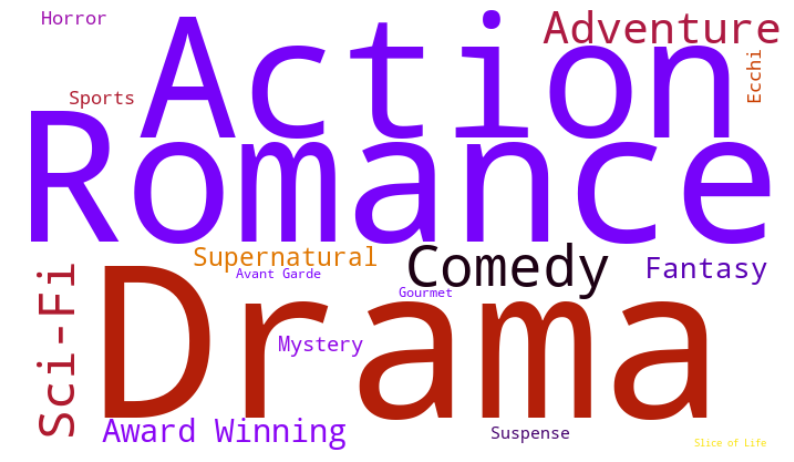

,Name,Genres
0,Cowboy Bebop,"Action, Award Winning, Sci-Fi"
11,One Piece,"Action, Adventure, Fantasy"
24,Koukaku Kidoutai,"Action, Award Winning, Mystery, Sci-Fi, Suspense"
25,Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuioku-hen,"Action, Drama, Romance"
26,Rurouni Kenshin: Meiji Kenkaku Romantan,"Action, Adventure, Comedy, Romance"


In [35]:
# Get user preferences for the random user
user_pref = get_user_preferences(random_user, plot=True, verbose=1)
pd.DataFrame(user_pref).head(5)

## Part 3: Recommending Animes for a User
#### In the final part, we recommend animes to the selected user based on the preferences of similar users. The get_recommended_animes function iterates through the list of similar users, retrieves their preferences, and identifies animes that are not present in the preferences of the selected user. It then generates a list of recommended animes along with their genres and a brief synopsis. The output is a dataframe containing the recommended animes for the user.

In [36]:
def get_recommended_animes(similar_users, user_pref, n=10):
    recommended_animes = []
    anime_list = []
    
    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id))
        if not pref_list.empty:  # Check if user has watched any animes
            pref_list = pref_list[~pref_list["Name"].isin(user_pref["Name"].values)]
            anime_list.append(pref_list.Name.values)
            
    if len(anime_list) == 0:
        print("No anime recommendations available for the given users.")
        return pd.DataFrame()
    
    anime_list = pd.DataFrame(anime_list)
    sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)
    # Count the occurrences of each anime in the entire dataset
    anime_count = df['anime_id'].value_counts()
    
    for i, anime_name in enumerate(sorted_list.index):
        if isinstance(anime_name, str):
            try:
                anime_id = df_anime[df_anime.Name == anime_name].anime_id.values[0]
                english_name = df_anime[df_anime['Name'] == anime_name]['English name'].values[0]
                name = english_name if english_name != "UNKNOWN" else anime_name
                genre = df_anime[df_anime.Name == anime_name].Genres.values[0]
                Synopsis = df_anime[df_anime.Name == anime_name].Synopsis.values[0]
                n_user_pref = anime_count.get(anime_id, 0)  # Get the total count of users who have watched this anime
                recommended_animes.append({
                    "n": n_user_pref,
                    "anime_name": anime_name, 
                    "Genres": genre, 
                    "Synopsis": Synopsis
                })
            except:
                pass
    return pd.DataFrame(recommended_animes)

In [37]:
# Get recommended animes for the random user
recommended_animes = get_recommended_animes(similar_users, user_pref, n=10)

print('\n> Top recommendations for user: {}'.format(random_user))
recommended_animes


> Top recommendations for user: 37107


,n,anime_name,Genres,Synopsis
0,34185,Kimi ni Todoke,"Drama, Romance","Known for her semblance to the Sadako character of The Ring series, Sawako Kuronuma is given the nickname ""Sadako"" and misunderstood to be frightening and malicious like her fictional counterpart, despite having a timid and sweet nature. Longing to make friends and live a normal life, Sawako is naturally drawn to the cheerful and friendly Shouta Kazehaya, the most popular boy in her class. From their first meeting, Sawako has admired Kazehaya's ability to be the center of attention and aspires to be like him.\n\nWhen Kazehaya organizes a test of courage for the entire class and encourages her to attend, Sawako sees this as an opportunity to get along with her classmates, starting with Ayane Yano and Chizuru Yoshida. Through each new encounter and emotion she experiences, Sawako believes that meeting Kazehaya has changed her for the better. Little does Sawako know, her presence has also changed Kazehaya."
1,126492,Death Note,"Supernatural, Suspense","Brutal murders, petty thefts, and senseless violence pollute the human world. In contrast, the realm of death gods is a humdrum, unchanging gambling den. The ingenious 17-year-old Japanese student Light Yagami and sadistic god of death Ryuk share one belief: their worlds are rotten.\n\nFor his own amusement, Ryuk drops his Death Note into the human world. Light stumbles upon it, deeming the first of its rules ridiculous: the human whose name is written in this note shall die. However, the temptation is too great, and Light experiments by writing a felon's name, which disturbingly enacts his first murder.\n\nAware of the terrifying godlike power that has fallen into his hands, Light—under the alias Kira—follows his wicked sense of justice with the ultimate goal of cleansing the world of all evil-doers. The meticulous mastermind detective L is already on his trail, but as Light's brilliance rivals L's, the grand chase for Kira turns into an intense battle of wits that can only end when one of them is dead."
2,16718,Inu x Boku SS,"Comedy, Romance, Supernatural","Ririchiyo Shirakiin is the sheltered daughter of a renowned family. With her petite build and wealthy status, Ririchiyo has been a protected and dependent girl her entire life, but now she has decided to change all that. However, there is just one problem—the young girl has a sharp tongue she can't control, and terrible communication skills.\n\nWith some help from a childhood friend, Ririchiyo takes up residence in Maison de Ayakashi, a secluded high-security apartment complex that, as the unsociable 15-year-old soon discovers, is home to a host of bizarre individuals. Furthermore, their quirky personalities are not the strangest things about them: each inhabitant of the Maison de Ayakashi, including Ririchiyo, is actually half-human, half-youkai.\n\nBut Ririchiyo's troubles have only just begun. As a requirement of staying in her new home, she must be accompanied by a Secret Service agent. Ririchiyo's new partner, Soushi Miketsukami, is handsome, quiet... but ridiculously clingy and creepily submissive. With Soushi, her new supernatural neighbors, and the beginning of high school, Ririchiyo definitely seems to have a difficult path ahead of her."
3,11787,Persona 4 the Animation,"Action, Adventure, Mystery, Sci-Fi, Supernatural","Serial murders have recently plagued Inaba, with the police struggling to find any leads. Despite this, due to his parents going abroad for work, Yuu Narukami moves to the small town to live with his uncle for a year. He enrolls at Yasogami High School, where he meets and befriends Yousuke Hanamura, Chie Satonaka, and Yukiko Amagi.\n\nWhile hanging out together after school, the group fills Yuu in on the urban legend known as the ""Midnight Channel""—a mysterious TV channel that only appears at midnight on rainy days while the viewer is alone. Curious about the claim, Yuu decides to tune in that night, only to see the next victim

# Model training (content-based filtering)

In [38]:
# Create a TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Define a generator to compute TF-IDF matrix on the fly
tfidf_matrix_generator = tfidf.fit_transform((genre for genre in df_anime['Genres'].values.astype('U')))

# Compute cosine similarity matrix as a sparse matrix
cosine_sim_sparse = linear_kernel(tfidf_matrix_generator, tfidf_matrix_generator)

# 2: Content-Based Recommendation

In [39]:
# Function to get recommendations based on cosine similarity, genre, and ratings based on score
def get_recommendations(title, cosine_sim, df):
    idx = df_anime[df_anime['Name'] == title].index[0]

    # Compute the similarity scores between the anime at the given index and all other animes
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Filter out animes with unknown scores
    valid_scores = [x for x in sim_scores if df_anime.iloc[x[0]]['Score'] != "UNKNOWN"]

    # Sort the valid anime similarity scores based on the cosine similarity and ratings score in descending order
    sorted_scores = sorted(valid_scores, key=lambda x: (x[1], df_anime.iloc[x[0]]['Score']), reverse=True)

    # Get the top 10 similar animes (excluding the anime itself)
    top_animes = [x for x in sorted_scores if x[0] != idx][:10]

    # Extract the indices of the recommended animes
    recommended_indices = [idx for idx, _ in top_animes]
    recommended_animes = df_anime.iloc[recommended_indices][['Name', 'Genres', 'Score']]
    return recommended_animes

In [40]:
# Example usage: Get recommendations for an anime
anime_title = 'Kono Subarashii Sekai ni Shukufuku wo!'
recommendations = get_recommendations(anime_title, cosine_sim_sparse, df_anime)
print(f'Recommendations for "{anime_title}":')
recommendations

Recommendations for "Kono Subarashii Sekai ni Shukufuku wo!":


,Name,Genres,Score
14578,Kono Subarashii Sekai ni Shukufuku wo! Movie: Kurenai Densetsu,"Adventure, Comedy, Fantasy",8.45
11572,Kono Subarashii Sekai ni Shukufuku wo! 2,"Adventure, Comedy, Fantasy",8.27
6241,Doraemon Movie 31: Shin Nobita to Tetsujin Heidan - Habatake Tenshi-tachi,"Adventure, Comedy, Fantasy",8.14
12451,Kono Subarashii Sekai ni Shukufuku wo! 2: Kono Subarashii Geijutsu ni Shukufuku wo!,"Adventure, Comedy, Fantasy",8.03
502,Slayers Next,"Adventure, Comedy, Fantasy",8.02
1068,Slayers Try,"Adventure, Comedy, Fantasy",7.81
11859,Little Witch Academia (TV),"Adventure, Comedy, Fantasy",7.81
12531,Mahoujin Guruguru (2017),"Adventure, Comedy, Fantasy",7.81
7105,Little Witch Academia,"Adventure, Comedy, Fantasy",7.8
8061,Little Witch Academia: Mahoujikake no Parade,"Adventure, Comedy, Fantasy",7.75


In [41]:
anime_title = 'One Piece'
recommendations = get_recommendations(anime_title, cosine_sim_sparse, df_anime)
print(f'Recommendations for "{anime_title}":')
recommendations

Recommendations for "One Piece":


,Name,Genres,Score
16617,Bleach: Sennen Kessen-hen,"Action, Adventure, Fantasy",9.07
6456,Hunter x Hunter (2011),"Action, Adventure, Fantasy",9.04
115,Hunter x Hunter,"Action, Adventure, Fantasy",8.41
116,Hunter x Hunter: Original Video Animation,"Action, Adventure, Fantasy",8.31
1574,Naruto: Shippuuden,"Action, Adventure, Fantasy",8.26
19600,Jigokuraku,"Action, Adventure, Fantasy",8.26
118,Hunter x Hunter: Greed Island Final,"Action, Adventure, Fantasy",8.25
23239,Dungeon ni Deai wo Motomeru no wa Machigatteiru Darou ka IV: Fuka Shou - Yakusai-hen,"Action, Adventure, Fantasy",8.24
7799,Magi: The Kingdom of Magic,"Action, Adventure, Fantasy",8.22
14699,One Piece Movie 14: Stampede,"Action, Adventure, Fantasy",8.22
